In [1]:
import numpy as np

datasets = np.load('npz/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

labels = []
for num in numbers:
    cls = [1] * num if num != 0 else [0]
    labels.append(cls)


# labels = np.array(labels)

print(images.shape, numbers.shape, bboxes.shape, len(labels))
print(images.max(), images.min())
print(bboxes[:3])
print(labels[999:1010])


dataset = {
    'images' : images,
    'numbers' : numbers,
    'bboxes' : bboxes,
    'cls' : labels
}

print(dataset['images'].shape)
print(dataset['numbers'].shape)
print(dataset['bboxes'].shape)
print(len(dataset['cls']))


(13276, 24, 32, 1) (13276,) (13276, 4, 4) 13276
255 0
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
[[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]
(13276, 24, 32, 1)
(13276,)
(13276, 4, 4)
13276


In [2]:
print(labels[9000])

[1, 1, 1, 1]


2024-01-17 11:32:11.883993: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-17 11:32:11.931705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 11:32:12.706895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(24, 32, 1)
1
32
tf.Tensor(
[[ 8. 15. 15. 24.]
 [ 0.  0.  8.  8.]
 [15. 13. 23. 23.]
 [26. 16. 32. 24.]], shape=(4, 4), dtype=float64)


2024-01-17 11:32:24.113413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-01-17 11:32:24.115155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22292 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-01-17 11:32:24.116743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22292 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-01-17 11:32:24.118341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22292 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

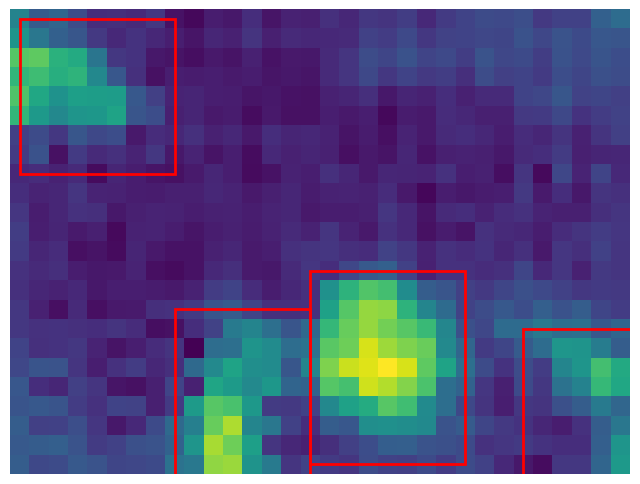

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
images = dataset['images']
numbers =dataset['numbers']
bboxes = dataset['bboxes']
cls = dataset['cls']

boxes = bboxes[9000]
plt.figure(figsize = (8, 8))
plt.axis('off')
image = images[9000]
print(image.shape)
print(image.shape[2])
print(image.shape[1])
plt.imshow(images[9000])
ax = plt.gca()
boxes = tf.stack([
	boxes[:, 0] * images.shape[2],
	boxes[:, 1] * images.shape[1],
	boxes[:, 2] * images.shape[2],
	boxes[:, 3] * images.shape[1]], axis = -1
)

print(boxes)

for box in boxes:
	xmin, ymin = box[:2]
	w, h = box[2:] - box[:2]
	patch = plt.Rectangle(
		[xmin, ymin], w, h, fill = False, edgecolor = [1, 0, 0], linewidth = 2
	)
	ax.add_patch(patch)
plt.show()

In [4]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_TRAIN = int(images.shape[0] * 0.7)
N_VAL = images.shape[0] - N_TRAIN
LOG_DIR = 'ObjectDetectionLog'

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)
print("N_VAL:           ", N_VAL)


IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           13276
N_TRAIN:          9293
N_VAL:            3983


In [5]:
shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)


In [6]:
images.max(), images.min()

(255, 0)

In [7]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))


def _bytes_feature_list(value_list):
    """value_list가 리스트일 때, 이를 serialize하여 bytes list로 변환하는 함수."""
    value_list = [tf.io.serialize_tensor(tf.constant(v)).numpy() for v in value_list]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value_list))


In [8]:
# 가장 긴 라벨 리스트의 길이 찾기
max_label_length = max(len(cls) for cls in labels)

for idx in train_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    cls = [1] * number if number != 0 else [-1]

    cls += [-1] * (max_label_length - len(cls))

    serialized_cls = tf.io.serialize_tensor(tf.constant(cls)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
    }))
    
    writer_train.write(example.SerializeToString())
writer_train.close()


In [9]:
# 가장 긴 라벨 리스트의 길이 찾기
max_label_length = max(len(cls) for cls in labels)

for idx in val_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    cls = [1] * number if number != 0 else [-1]

    # 모든 리스트를 동일한 길이로 패딩
    cls += [-1] * (max_label_length - len(cls))

    serialized_cls = tf.io.serialize_tensor(tf.constant(cls)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
    }))
    
    writer_val.write(example.SerializeToString())
writer_val.close()


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT =24
RES_WIDTH = 32
# N_EPOCHS = 100
# N_BATCH = 8
# LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
        # 'count': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = tf.cast(image, tf.float32) 

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    # num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int32)
    # count = tf.cast(parsed_features['count'], tf.int64)
    

    return image, bbox, label


train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
# train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)


(24, 32, 1)
tf.Tensor(
[[ 0. 16.  9. 24.]
 [ 9. 12. 19. 23.]
 [19. 14. 29. 24.]
 [24.  0. 32.  8.]], shape=(4, 4), dtype=float32)


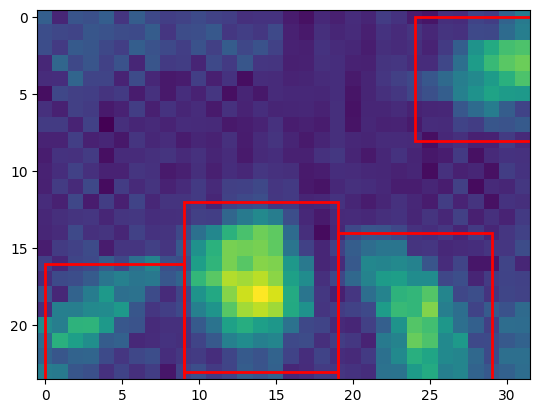

tf.Tensor([1 1 1 1], shape=(4,), dtype=int32)
(24, 32, 1)
tf.Tensor(
[[23. 10. 32. 18.]
 [ 0.  5.  9. 12.]
 [ 0.  0.  7.  5.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


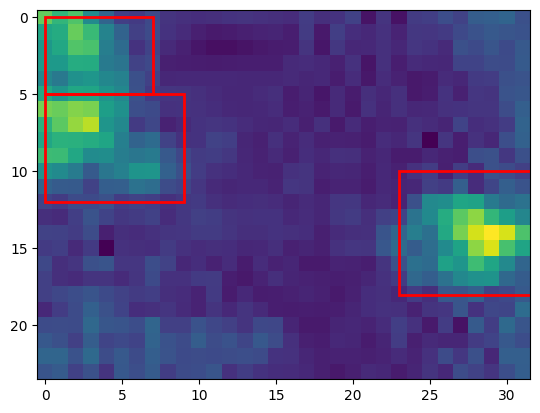

tf.Tensor([ 1  1  1 -1], shape=(4,), dtype=int32)
(24, 32, 1)
tf.Tensor(
[[ 0. 17.  7. 24.]
 [ 0.  7.  7. 17.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


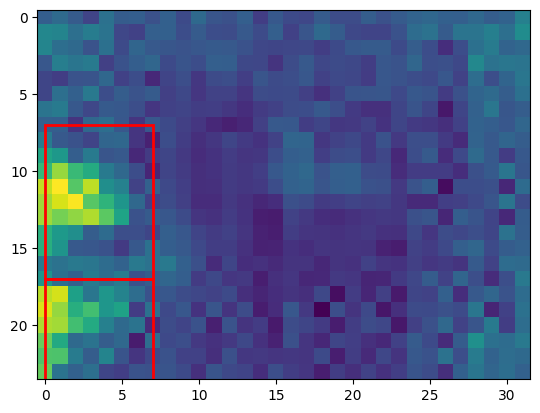

tf.Tensor([ 1  1 -1 -1], shape=(4,), dtype=int32)
(24, 32, 1)
tf.Tensor(
[[10.  5. 18. 14.]
 [18. 10. 28. 20.]
 [ 6.  8. 13. 17.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


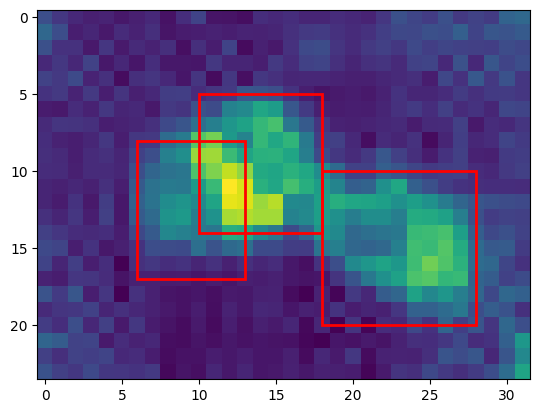

tf.Tensor([ 1  1  1 -1], shape=(4,), dtype=int32)
(24, 32, 1)
tf.Tensor(
[[14. 10. 24. 22.]
 [ 0. 14. 10. 23.]
 [ 0.  9.  7. 14.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


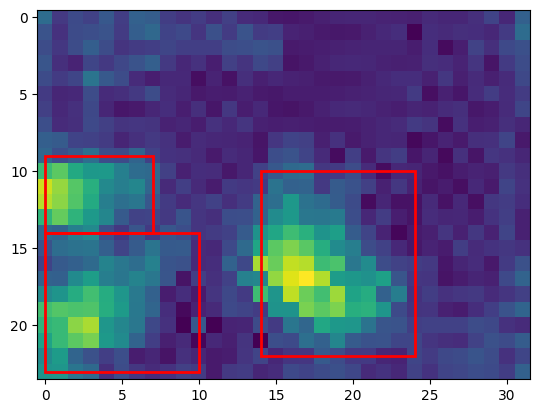

tf.Tensor([ 1  1  1 -1], shape=(4,), dtype=int32)


In [11]:
import matplotlib.pyplot as plt

for image, bbox, label in val_dataset.take(5):
    image = image.numpy()
    
    # print(image.shape)
    # plt.axis('off')
    plt.imshow(image)
    ax = plt.gca()  

    boxes = tf.stack(
    	[
    	 bbox[:,0] * image.shape[1],
    	 bbox[:,1] * image.shape[0],
    	 bbox[:,2] * image.shape[1],
    	 bbox[:,3] * image.shape[0]
    	], axis = -1
    )
    print(image.shape)
    print(boxes)
    for box in boxes:
        xmin, ymin = box[:2]
        w, h = box[2:] - box[:2]
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()
    print(label)

In [12]:
# import matplotlib.pyplot as plt

# boxes = bboxes[9000]
# plt.figure(figsize = (8, 8))
# plt.axis('off')
# plt.imshow(images[9000])
# ax = plt.gca()

# for box in boxes:
# 	xmin, ymin = box[:2]
# 	w, h = box[2:] - box[:2]
# 	patch = plt.Rectangle(
# 		[xmin, ymin], w, h, fill = False, edgecolor = [1, 0, 0], linewidth = 2
# 	)
# 	ax.add_patch(patch)
# plt.show()

# image, bbox, count, label

In [13]:
def convert_to_xywh(boxes):    
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

In [14]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )

In [15]:
def resize_and_pad_image(image, ratio = 3, stride = 8):
    image_shape = tf.cast(tf.shape(image)[:2], dtype = tf.float32)
    
    image_shape = ratio * image_shape

    image = tf.image.resize(image, tf.cast(image_shape, dtype = tf.int32))

    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype = tf.int32
    )

    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )

    return image, image_shape, ratio



In [16]:
# images = dataset['images']
# numbers =dataset['numbers']
# bboxes = dataset['bboxes']
# cls = dataset['cls']

def preprocess_data(image, gt_boxes, cls_ids):
    # image = sample["images"]
    # bbox = sample["bboxes"]
    class_id = tf.cast(cls_ids, dtype = tf.int32)

    image, image_shape, _ = resize_and_pad_image(image)
    bbox = tf.stack([
        gt_boxes[:, 0] * image_shape[1],
        gt_boxes[:, 1] * image_shape[0],
        gt_boxes[:, 2] * image_shape[1],
        gt_boxes[:, 3] * image_shape[0]],
        axis = -1
    )
    bbox = convert_to_xywh(bbox)

    return image, bbox, class_id
    
    

tf.Tensor([1 1 1 1], shape=(4,), dtype=int32)
(72, 96, 1)
(72, 96, 3)


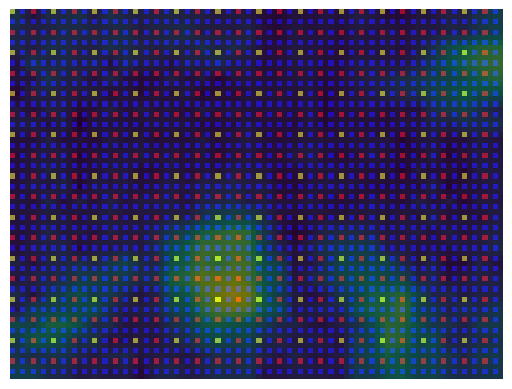

In [17]:
import numpy as np
import matplotlib.pyplot as plt
# 이미지의 크기를 줄여서 설정 (예시: 100x100)
# images = dataset['images']
# numbers = dataset['numbers']
# bboxes = dataset['bboxes']
# cls = dataset['cls']
# 이미지 생성 (흰색 배경)
# img = images[9000]
# num = numbers[9000]
# bb = bboxes[9000]
# cs = cls[9000]
# sample = {
#     'images' : img,
#     'bboxes' : bb,
#     'cls' : cs,
# }
for image, bbox, label in val_dataset.take(1):
    print(label)
    img, _, _ = preprocess_data(image, bbox, label)
    print(img.shape) # (72, 96, 1)

    anchor_img = np.zeros((*img.shape[:2], 3), dtype=np.uint8)
    print(anchor_img.shape)

    strides = [2, 4, 8]
    colors = {
        # 2: [0, 255, 0],  # 초록색
        2: [0, 0, 255],  # 파란색
        4: [255, 0, 0],   # 빨간색
        8:[255, 255, 0]  # 노란색
    }

    for stride in strides:
        color = colors[stride]
        for y in range(0, anchor_img.shape[0], stride):
            for x in range(0, anchor_img.shape[1], stride):
                anchor_img[y, x, :] = color

    # 이미지 표시
    plt.imshow(img, alpha=1)  
    plt.imshow(anchor_img, alpha=0.5) 
    plt.axis('off')
    plt.show()

In [18]:
import math
ratios = [0.5, 1.0, 2.0]
areas = [16, 64, 256]

for area in areas:
    for ratio in ratios:
        H = math.sqrt(area / ratio)
        W = area / H
        print(f'Area: {area}')
        print(f'Ratio: {ratio}')
        print(f'Height: {H}\nWidth: {W}\n')
    

Area: 16
Ratio: 0.5
Height: 5.656854249492381
Width: 2.82842712474619

Area: 16
Ratio: 1.0
Height: 4.0
Width: 4.0

Area: 16
Ratio: 2.0
Height: 2.8284271247461903
Width: 5.65685424949238

Area: 64
Ratio: 0.5
Height: 11.313708498984761
Width: 5.65685424949238

Area: 64
Ratio: 1.0
Height: 8.0
Width: 8.0

Area: 64
Ratio: 2.0
Height: 5.656854249492381
Width: 11.31370849898476

Area: 256
Ratio: 0.5
Height: 22.627416997969522
Width: 11.31370849898476

Area: 256
Ratio: 1.0
Height: 16.0
Width: 16.0

Area: 256
Ratio: 2.0
Height: 11.313708498984761
Width: 22.62741699796952



dataset = {
    'images' : images,
    'numbers' : numbers,
    'bboxes' : bboxes,
    'cls' : cls
}

In [19]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]        
        self.scales = [2** x for x in [0, 1/3, 2/3]]
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(1, 4)]
        self._areas = [x ** 2 for x in [4, 8, 16]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []

        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios: 
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis = -1), [1, 1, 2]
                )
                for scale in self.scales: 
                    anchor_dims.append(scale * dims) 
            anchor_dims_all.append(tf.stack(anchor_dims, axis = -2))
        return anchor_dims_all 
    
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype = tf.float32) + 0.5
        ry = tf.range(feature_height, dtype = tf.float32) + 0.5

        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level -1]
        centers = tf.expand_dims(centers, axis = -2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])

        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1] 
        )
        print(f"dims: {dims}")
        anchors = tf.concat([centers, dims], axis=-1) 

        print(f"{tf.reshape(anchors, [feature_height * feature_width * self._num_anchors, 4]).shape}")

        anchors = tf.clip_by_value(anchors, 0.0, [96, 72, 96, 72])

        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), # 올림
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(1, 4)
        ]
        print(tf.concat(anchors, axis=0))
        return tf.concat(anchors, axis=0)

In [20]:
anchors = AnchorBox()
anchor = anchors.get_anchors(72, 96)

dims: [[[[ 5.656854  11.313708 ]
   [ 7.1271896 14.254379 ]
   [ 8.979696  17.959393 ]
   ...
   [11.313708   5.656854 ]
   [14.254379   7.1271896]
   [17.959393   8.979696 ]]

  [[ 5.656854  11.313708 ]
   [ 7.1271896 14.254379 ]
   [ 8.979696  17.959393 ]
   ...
   [11.313708   5.656854 ]
   [14.254379   7.1271896]
   [17.959393   8.979696 ]]

  [[ 5.656854  11.313708 ]
   [ 7.1271896 14.254379 ]
   [ 8.979696  17.959393 ]
   ...
   [11.313708   5.656854 ]
   [14.254379   7.1271896]
   [17.959393   8.979696 ]]

  ...

  [[ 5.656854  11.313708 ]
   [ 7.1271896 14.254379 ]
   [ 8.979696  17.959393 ]
   ...
   [11.313708   5.656854 ]
   [14.254379   7.1271896]
   [17.959393   8.979696 ]]

  [[ 5.656854  11.313708 ]
   [ 7.1271896 14.254379 ]
   [ 8.979696  17.959393 ]
   ...
   [11.313708   5.656854 ]
   [14.254379   7.1271896]
   [17.959393   8.979696 ]]

  [[ 5.656854  11.313708 ]
   [ 7.1271896 14.254379 ]
   [ 8.979696  17.959393 ]
   ...
   [11.313708   5.656854 ]
   [14.254379   7

(20412, 4)


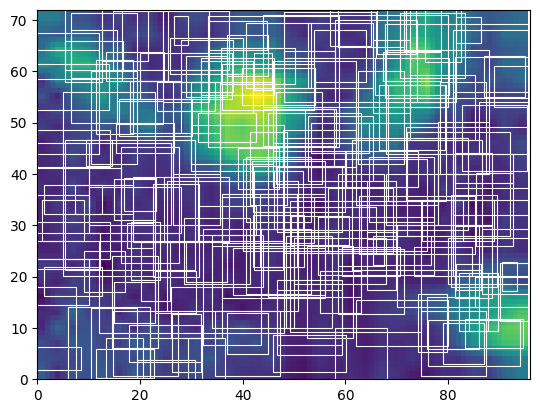

In [21]:
print(anchor.shape)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(data, num_samples):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 96)
    ax.set_ylim(0, 72)

    ax.imshow(img)
    data_np = data.numpy()

    if len(data) > num_samples:
        sampled_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_data = data_np[sampled_indices]
    else : 
        sample_data = data_np

    for center_x, center_y, width, height in sample_data:
        top_left_x = center_x - width / 2
        top_left_y = center_y - height / 2

        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=0.8, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

draw_bounding_boxes(anchor, 200)


In [22]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])  # 변경: tf.maximum -> tf.minimum
    intersection = tf.maximum(rd - lu, 0.0)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


In [23]:
def check_anchor_box_coordinates(anchors, image_height, image_width):
    x = anchors[:, 0]
    y = anchors[:, 1]
    width = anchors[:, 2]
    height = anchors[:, 3]
    
    # Check if coordinates are non-negative
    non_negative_x = tf.math.greater_equal(x, 0)
    non_negative_y = tf.math.greater_equal(y, 0)
    
    # Check if coordinates are within image dimensions
    within_image_width = tf.math.less_equal(x + width, image_width)
    within_image_height = tf.math.less_equal(y + height, image_height)
    
    # Combine the checks
    is_within_image = tf.math.logical_and(
        tf.math.logical_and(non_negative_x, non_negative_y),
        tf.math.logical_and(within_image_width, within_image_height)
    )
    
    return is_within_image

check_anchor_box_coordinates(anchor, 72, 96)


<tf.Tensor: shape=(20412,), dtype=bool, numpy=array([ True,  True,  True, ..., False, False, False])>

In [24]:
# # b1 = np.array([])
# b1 = np.array([[92, 68, 8.979696, 4.489848]])
# b2 = np.array([[92, 68, 5.656854, 2.828427 ]])
# result = compute_iou(b1, b2)
# print(result)

In [25]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    
    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)

        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis = -1,
        )
        box_target = box_target / self._box_variance
        return box_target
    
    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):       
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
          label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
          labels = labels.write(i, label)
        # batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [26]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
num_classes = 1
batch_size = 2

train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(batch_size * 8)

train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, 
    padded_shapes = ([72, 96, 1], [None, 4], [max_label_length]),
    padding_values=(0.0, 1e-8, -1), 
    drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=batch_size, 
    padded_shapes = ([72, 96, 1], [None, 4], [max_label_length]),
    padding_values=(0.0, 1e-8, -1), 
    drop_remainder=True
)
val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

dims: Tensor("while/Tile_1:0", shape=(None, None, 9, 2), dtype=float32)
(None, 4)
dims: Tensor("while/Tile_3:0", shape=(None, None, 9, 2), dtype=float32)
(None, 4)
dims: Tensor("while/Tile_5:0", shape=(None, None, 9, 2), dtype=float32)
(None, 4)
Tensor("while/concat_3:0", shape=(None, 4), dtype=float32)
Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.
dims: Tensor("while/Tile_1:0", shape=(None, None, 9, 2), dtype=float32)
(None, 4)
dims: Tensor("while/Tile_3:0", shape=(None, None, 9, 2), dtype=float32)
(None, 4)
dims: Tensor("while/Tile_5:0", shape=(None, None, 9, 2), dtype=float32)
(None, 4)
Tensor("while/concat_3:0", shape=(None, 4), dtype=float32)


In [27]:
# train_dataset에서 하나의 배치를 가져옵니다
for batch in train_dataset.take(1):
    # 배치에서 이미지와 레이블을 추출합니다
    images, labels = batch
    
    # 이미지와 레이블의 형태를 출력합니다
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print(labels[:, :, :4])
    print(labels[:, :, 4])



Images shape: (2, 72, 96, 1)
Labels shape: (2, 20412, 5)
tf.Tensor(
[[[  56.568542    12.374369     8.341647     4.875911 ]
  [  44.89848      9.821543     7.186402     3.7206662]
  [  35.63595      7.7953634    6.0311565    2.5654206]
  ...
  [-104.29825   -187.3833       8.341647    11.807384 ]
  [ -82.78158   -148.72623      7.186402    10.652138 ]
  [ -65.70378   -118.04408      6.0311565    9.496893 ]]

 [[  53.916893    20.32932      6.5582724    3.7601938]
  [  42.793865    16.135391     5.403027     2.6049483]
  [  33.96551     12.806669     4.2477818    1.4497029]
  ...
  [-106.9499    -155.56349      6.5582724   10.691666 ]
  [ -84.8862    -123.47083      5.403027     9.53642  ]
  [ -67.374214   -97.998856     4.2477818    8.381175 ]]], shape=(2, 20412, 4), dtype=float32)
tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]], shape=(2, 20412), dtype=float32)


In [28]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.layers import BatchNormalization, Dropout, ZeroPadding2D
from keras.models import Model
from keras.layers import ZeroPadding2D
from keras.regularizers import l2
from keras.layers import Add

class BackBone:
    def __init__(self):
        self.l2_regularizer = l2(0.001)

    def residual_layer(self, feature_map, latent, name:str):
        add_layer = Add(name = name+'_output')([feature_map, latent])
        return add_layer

    def feature_extraction_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Activation('relu')(feature_map)
        feature_map = Dropout(0.3)(feature_map)

        feature_map = ZeroPadding2D(padding=((0, 1), (0, 1)), name=name+'_pad')(feature_map)
        feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 2, padding = 'valid', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        return feature_map

    def convolutional_residual_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        latent =  BatchNormalization()(latent)
        latent = Activation('relu')(latent)
        feature_map = Dropout(0.3)(feature_map)

        latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(latent)
        latent = BatchNormalization()(latent)
        residual_block = self.residual_layer(feature_map, latent, name)
        return residual_block
    
    def __call__(self, input_shape=(72, 96, 1)):
        inputs_image = Input(shape=input_shape)
        upsample_layer = Conv2DTranspose(filters = 6, kernel_size = 3, strides = (1, 1), padding = 'same')(inputs_image)
        block_1 = self.feature_extraction_block(upsample_layer, 3, 5,'block_1')
        block_1_output = self.convolutional_residual_block(block_1, 3, 5,'block_2')
        block_2 = self.feature_extraction_block(block_1_output, 3, 5, 'block_3')
        block_2_output = self.convolutional_residual_block(block_2, 3, 5, 'block_4')
        block_3 = self.feature_extraction_block(block_2_output, 3, 5,'block_5')
        block_3_output = self.convolutional_residual_block(block_3, 3, 5,'block_6')

        model = Model(inputs_image, block_3_output)
        return model

In [29]:
backbone = BackBone()
model = backbone()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72, 96, 1)]          0         []                            
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 72, 96, 6)            60        ['input_1[0][0]']             
 anspose)                                                                                         
                                                                                                  
 block_1 (Conv2D)            (None, 72, 96, 3)            165       ['conv2d_transpose[0][0]']    
                                                                                                  
 batch_normalization (Batch  (None, 72, 96, 3)            12        ['block_1[0][0]']         

In [30]:
import keras
def get_backbone():
    backbone = BackBone() 
    backbone = backbone(input_shape=[None, None, 1])

    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ['block_2_output', 'block_4_output', 'block_6_output']
    ]

    return keras.Model(
        inputs = [backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [31]:
class FeaturePyramid(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(5, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(5, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(5, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(5, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(5, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(5, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(5, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(5, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))        
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [32]:
def build_head(output_filters, bias_init):
    head = keras.Sequential([keras.Input(shape=[None, None, 5])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01, seed=1)

    for _ in range(4):
        head.add(
            keras.layers.Conv2D(5, 3, padding = 'same', kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())

    
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [33]:
class CustomNet(keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(CustomNet, self).__init__(name="CustomNet", **kwargs)
        self.fpn = FeaturePyramid()
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []

        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [34]:
class CustomNetBoxLoss(tf.losses.Loss):  
    def __init__(self, delta):
        super(CustomNetBoxLoss, self).__init__(
            reduction="none", name="CustomNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5
        )

        return tf.reduce_sum(loss, axis=-1)

In [35]:
class RetinaNetClassificationLoss(tf.losses.Loss):   
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy

        return tf.reduce_sum(loss, axis=-1)

In [43]:
num_classes = 1

In [44]:
class RetinaNetLoss(tf.losses.Loss):    
    def __init__(self, num_classes=num_classes, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._cls_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = CustomNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

        cls_loss = self._cls_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
        loss = cls_loss + box_loss
        return loss

In [45]:
num_classes = 1
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

model_dir = "ObjectDetectionCheckpoint/customnet.ckpt"

In [46]:
model = CustomNet(num_classes)
loss_fn = RetinaNetLoss()

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn)

model.compile(loss=loss_fn, optimizer=optimizer)

In [50]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

In [53]:
model.summary()

Model: "CustomNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeaturePyramid (FeaturePyr  multiple                  3187      
 amid)                                                           
                                                                 
 sequential_2 (Sequential)   (None, None, None, 9)     1334      
                                                                 
 sequential_3 (Sequential)   (None, None, None, 36)    2576      
                                                                 
Total params: 7097 (27.72 KB)
Trainable params: 7001 (27.35 KB)
Non-trainable params: 96 (384.00 Byte)
_________________________________________________________________


In [54]:
# train_dataset에서 하나의 배치를 가져옵니다
for batch in train_dataset.take(1):
    # 배치에서 이미지와 레이블을 추출합니다
    images, labels = batch
    
    # 이미지와 레이블의 형태를 출력합니다
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (2, 72, 96, 1)
Labels shape: (2, 20412, 5)
tf.Tensor(
[[[  85.736694    15.02602      8.818198     4.875911 ]
  [  68.04926     11.92616      7.662953     3.7206662]
  [  54.010735     9.465798     6.5077076    2.5654206]
  ...
  [ -75.1301    -176.77669      8.818198    11.807384 ]
  [ -59.6308    -140.30775      7.662953    10.652138 ]
  [ -47.328995  -111.36234      6.5077076    9.496893 ]]

 [[  85.736694    15.02602      7.814844     4.875911 ]
  [  68.04926     11.92616      6.6595993    3.7206662]
  [  54.010735     9.465798     5.504354     2.5654206]
  ...
  [ -75.1301    -176.77669      7.814844    11.807384 ]
  [ -59.6308    -140.30775      6.6595993   10.652138 ]
  [ -47.328995  -111.36234      5.504354     9.496893 ]]], shape=(2, 20412, 4), dtype=float32)
tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]], shape=(2, 20412), dtype=float32)


In [52]:
epochs = 10

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/10


2024-01-17 11:34:15.449321: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inCustomNet/FeaturePyramid/model_4/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-17 11:34:16.371462: W tensorflow/core/framework/op_kernel.cc:1816] INVALID_ARGUMENT: required broadcastable shapes
2024-01-17 11:34:16.371506: W tensorflow/core/framework/op_kernel.cc:1816] INVALID_ARGUMENT: required broadcastable shapes
2024-01-17 11:34:17.422442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-01-17 11:34:18.319778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-17 11:34:18.602182: W tensorflow/core/framework/op_kernel.cc:1816] INVALID_ARGUMENT: required broadcastable shapes
2024-01-17 11:34:18.602308: W tensorflo

InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/RetinaNetLoss/SelectV2_2' defined at (most recent call last):
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_48109/1155105844.py", line 3, in <module>
      model.fit(
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/RetinaNetLoss/SelectV2_2'
required broadcastable shapes
	 [[{{node gradient_tape/RetinaNetLoss/SelectV2_2}}]] [Op:__inference_train_function_69874]